In [1]:
import numpy as np 
import pandas as pd
import os

from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical  


## Importing Dataset

In [3]:
dataframe = pd.read_csv('dataset.csv')
dataframe.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


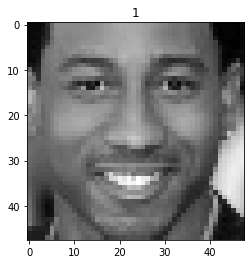

In [4]:
index = 5005
image = np.fromstring(dataframe['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(dataframe['ethnicity'][index])
plt.imshow(image, cmap ="gray")
plt.show()

In [2]:
EPOCHS = 70
BATCH_SIZE = 32

## Data Generator

In [5]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48, 48, 3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            #vertical_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.age_labels = []        
        self.ethnicity_labels = []
        self.gender_labels = []
        
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
        self.gender_labels = self.gender_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = self.ethnicity_labels[p]
        self.gender_labels = self.gender_labels[p]

In [6]:
msk = np.random.rand(len(dataframe)) < 0.8
train = dataframe[msk]
val = dataframe[~msk]

train_dataset = CustomDataGen(train, data_augmentation = True)
val_dataset = CustomDataGen(val)

18982it [00:03, 5405.47it/s]
4723it [00:00, 5720.29it/s]


231
5.0 [0. 0. 0. 1. 0.] 1.0


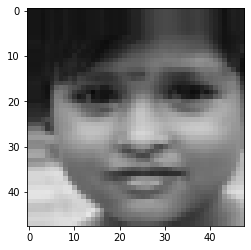

In [7]:
train_dataset.on_epoch_end()
x, y = train_dataset[450]
print(x[21].max())
print(y[0][0], y[1][0], y[2][0])
plt.imshow(x[0])

## Building Model

In [8]:
def build_model(input_shape = (48,48,3)):
    
    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output    
    
    
    def build_age_branch(input_tensor): 
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = None, name = 'age_output')(x)
    
        return x
    
    def build_etchnicity_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'ethnicity_output')(x)
    
        return x
    
    def build_gender_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)
    
        return x
    
    x = tf.keras.layers.Flatten()(output_layer)       
    output_age = build_age_branch(x)
    output_ethnicity = build_etchnicity_branch(x)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, [output_age, output_ethnicity, output_gender])
    
    return model
    

In [9]:
model = build_model()
model.summary()

2022-08-22 05:07:48.331010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 05:07:48.477009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 05:07:48.481281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 05:07:48.486128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 48, 48, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 48, 48, 3)    0           tf.cast[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 48, 48, 3)    0           tf.__operators__.getitem[0][0]   
_____________________________

## Training the Model

In [10]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_absolute_error', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('weights_v1.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = True)  ## Saves the best version of the model to disk (as measured on the validation data set)  

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau])

2022-08-22 05:40:00.883357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-08-22 05:40:04.624553: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


593/593 [==============================] - 42s 52ms/step - loss: 1.9591 - age_output_loss: 1204.2333 - ethnicity_output_loss: 1.0795 - gender_output_loss: 0.4302 - age_output_mean_absolute_error: 31.9809 - ethnicity_output_accuracy: 0.6265 - gender_output_accuracy: 0.8128 - val_loss: 1.6659 - val_age_output_loss: 1103.4797 - val_ethnicity_output_loss: 0.8272 - val_gender_output_loss: 0.2976 - val_age_output_mean_absolute_error: 31.5756 - val_ethnicity_output_accuracy: 0.6994 - val_gender_output_accuracy: 0.8763
Epoch 2/70
593/593 [==============================] - 28s 48ms/step - loss: 1.4006 - age_output_loss: 832.1915 - ethnicity_output_loss: 0.8135 - gender_output_loss: 0.3232 - age_output_mean_absolute_error: 26.5514 - ethnicity_output_accuracy: 0.7269 - gender_output_accuracy: 0.8607 - val_loss: 1.0622 - val_age_output_loss: 445.6701 - val_ethnicity_output_loss: 0.8855 - val_gender_output_loss: 0.3475 - val_age_output_mean_absolute_error: 19.0081 - val_ethnicity_output_accuracy: 0

## Evaluating the Model

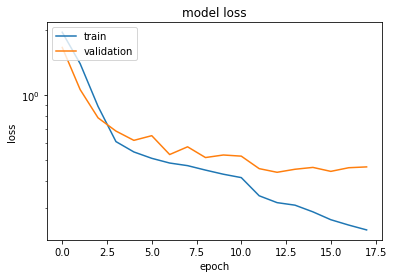

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.show()

## Testing the Model

In [12]:
model.load_weights('weights_v1.h5')
model.evaluate(val_dataset)

147/147 [==============================] - 2s 14ms/step - loss: 0.4382 - age_output_loss: 68.4766 - ethnicity_output_loss: 0.5504 - gender_output_loss: 0.1890 - age_output_mean_absolute_error: 5.9327 - ethnicity_output_accuracy: 0.8261 - gender_output_accuracy: 0.9252


[0.4381813406944275,
 68.47657775878906,
 0.5503957867622375,
 0.18901386857032776,
 5.9326863288879395,
 0.8261054158210754,
 0.9251700639724731]

In [13]:
names_ethnicity = ['white', 'black', 'asian', 'indian', 'other']
name_genders = ['male', 'female']

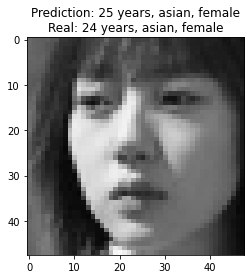

In [14]:
images, labels = val_dataset[22]
index = 0

p = model.predict(images)

gender_predictions = tf.where(p[2] > 0.5, 1, 0)
plt.title(f'Prediction: {p[0][index].astype(np.int)[0]} years, {names_ethnicity[p[1][index].argmax()]}, {name_genders[gender_predictions[index][0]]}\n'+
         f'Real: {int(labels[0][index])} years, {names_ethnicity[labels[1][index].argmax()]}, {name_genders[int(labels[2][index])]}')
plt.imshow(images[index])
plt.show()